In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model.PatchTST import PatchTST

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from torch_geometric.loader import DataLoader
from Data_provider import *
from exp import *

In [4]:
#参数表
parameter={"seq_len":96,"pred_len":24,"d_model":256,"n_heads":8,"e_layers":2,"c_out":1,"enc_in":1}#n_heads=1

In [5]:
df=pd.read_csv("./electricity.csv")
data=np.array(df["y"]).reshape(df["y"].shape[0],-1)

In [6]:
window_size=96
pred_size=24
train_data, test_data, scaler = normalize_and_split(data)

# 滑动窗口数据准备
train_windows = sliding_window(train_data, window_size,pred_size)
test_windows = sliding_window(test_data, window_size,pred_size)

In [7]:
train_dataset = create_dataset(train_windows)#drop 掉最后一个
test_dataset = create_dataset(test_windows)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
model=PatchTST(parameter)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 创建模型
model = PatchTST(parameter)

# 优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [11]:
#训练函数--Autoformer
def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch[0])
            #rint(batch.y.size())
            y = batch[1]
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [12]:
#测试函数--Autoformer
def pred(model,test_loader):
    out_list=[]
    true_list=[]
    for batch in test_loader:
        out=model(batch[0])
        #print(out.shape)
        true=batch[1]
        out_list.append(out.detach().numpy())
        true_list.append(true.detach().numpy())
    
    return np.vstack(out_list),np.vstack(true_list)

In [13]:
train(model, train_loader, optimizer, criterion, epochs=10)

Epoch: 1, Loss: 0.00824518222361803
Epoch: 2, Loss: 0.005689694546163082
Epoch: 3, Loss: 0.00601482717320323
Epoch: 4, Loss: 0.004044017754495144
Epoch: 5, Loss: 0.0036481565330177546
Epoch: 6, Loss: 0.0032469246070832014
Epoch: 7, Loss: 0.0036034109070897102
Epoch: 8, Loss: 0.0019681768026202917
Epoch: 9, Loss: 0.0023397323675453663
Epoch: 10, Loss: 0.0030496111139655113


In [14]:
y_hat,y_true=pred(model,test_loader)

In [15]:
mse,mae=Metrics(y_hat.reshape(-1,1),y_true.reshape(-1,1))

0.002376739
0.035773948


In [16]:
pred=inverse_transform(y_hat)
true=inverse_transform(y_true)

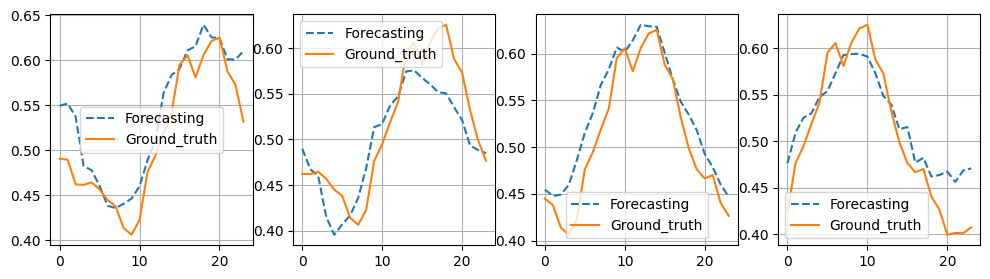

In [17]:
plt.figure(figsize=(12,3))
aa=111
window_size=24

plt.subplot(141)
plt.plot(pred[2],"--")
plt.plot(true[2])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(142)
plt.plot(pred[4],"--")
plt.plot(true[4])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(143)
plt.plot(pred[8],"--")
plt.plot(true[8])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(144)
plt.plot(pred[12],"--")
plt.plot(true[12])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)